# Overview
A conceptual model for the problem would be:
\begin{array}{rl}
    \text{min} & \text{unused volume in used bins} \\
    \text{subject to}   & \text{all items assigned to one and only one bin} \\
                        & \text{all items within the bin dimensions} \\
                        & \text{no overlaps between items in the same bin} \\
                        & \text{all items with support} \\
\end{array}

The model also need to account for 90° rotations on the same plane which can be modeled as swapping its width and depth.

# MILP Model
## Sets
\begin{array}{rl}
    I = \{1 \dots n \} & \text{set of items} \\
\end{array}

## Parameters
\begin{array}{rll}
    W \times D \times H & \text{width $\times$ depth $\times$ height of a bin} & \\
    V & \text{bin volume} & \\
    w \times d \times h & \text{width $\times$ depth $\times$ height of an item} & \\
    \alpha_s & \text{support coefficient} & \\
    \beta_s & \text{support tolerance} & \\
\end{array}

## Variables
\begin{array}{rll}
    (x_i,y_i,z_i) & \text{bottom front left corner of an item} & \forall i \in I \\
    (x'_i,y'_i) & \text{back right corner of an item} & \forall i \in I \\
    (x^{\text{max}}_{ik},y^{\text{max}}_{ik}) & \text{the maximum top back right coordinate along each axis between items $i,k$} & \forall i,k \in I \\
    (x^{\text{min}}_{ik},y^{\text{min}}_{ik}) & \text{the minimum bottom front left coordinate along each axis between items $i,k$} & \forall i,k \in I \\
    r_i & \begin{cases}
                1, \text{if item $i$ is rotated 90° over its z-axis} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I \\
    x^p_{ik} & \begin{cases}
                1, \text{if $x_i \le x'_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    y^p_{ik} & \begin{cases}
                1, \text{if $y_i \le y'_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    z^p_{ik} & \begin{cases}
                1, \text{if $z_i \le z_k + h$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    z^c_{ik} & \begin{cases}
                1, \text{if $0 \le z_k - (z_i + h) \le \beta_s$ } \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    s_{ik} & \begin{cases}
                1, \text{if item $k$ offers support to item $i$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    q_i & \begin{cases}
                1, \text{if item $i$ is on the ground} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I \\
    (t^x_{ik}, t^y_{ik}) & \text{the overlap edge length between item $i,k$ } & \forall i,k \in I \\
    z^\text{max} & \text{maximum height of the bin} & \\
\end{array}

Where $i,k \in I$ and $x_i,y_i,z_i,x'_i,y'_i \in \mathbb{Z}^+$.

The definition of the point $x'_i,y'_i$ of an item is mostly used to facilitate the concept of rotations.

An overlap on axis $a$ occurs if $a^p_{ik} \land a^p_{ki}$

## Objective Function
\begin{array}{rll}
    \text{min} & z^\text{max} & \text{(1)} \\
\end{array}

(1) minimizes the number of opened bins

## Constraints
\begin{array}{lll}
    x'_i - x_i = w(1 - r_i) + d r_i & \forall i \in I & (4) \\
    y'_i - y_i = d(1 - r_i) + w r_i & \forall i \in I & (5) \\
    x'_i \le W & \forall i \in I & (6) \\
    y'_i \le D & \forall i \in I & (7) \\
    z_i \le H - h & \forall i \in I & (8) \\
    z^\text{max} \ge z_i + h & \forall i \in I & (9)
\end{array}

(4,5) define the concept of rotating an item 90° over its z-axis.

(6,7,8) ensure that all the items are within the bin

(9) ensures that z^\text{max} converges to the top of the heighest placed item

### Overlap

\begin{array}{lll}
    x_i - x'_k < W(1 - x^p_{ik}) & \forall i,k \in I & (10) \\
    x'_k - x_i \le Wx^p_{ik} & \forall i,k \in I & (11) \\
    y_i - y'_k < D(1 - y^p_{ik}) & \forall i,k \in I & (12) \\
    y'_k - y_i \le Dy^p_{ik} & \forall i,k \in I & (13) \\
    z_i - (z_k + h) < H(1 - z^p_{ik}) & \forall i,k \in I & (14) \\
    z_k + h - z_i \le Wz^p_{ik} & \forall i,k \in I & (15) \\
    x^p_{ik} + x^p_{ki} + y^p_{ik} + y^p_{ki} + z^p_{ik} + z^p_{ki} \le 5 & \forall (i,k)  \in I &  (16)
\end{array}

(10-15) fully define the precedence variables on each axis, and ensure that if on axis $a$ items $i,k$ are such that $a_i = a'_k$ then $a^p_{ik} = 0$.

(16) ensures that overlap is only present at maximum on 2 axis. An overlap occurs if i precedes k and k precedes i over an axis.

### Support

\begin{array}{lll}
    s_{ik} \le (1 - z^p_{ik}) & \forall (i,k) \in I & (20) \\
    s_{ik} \le z^c_{ki} & \forall (i,k) \in I & (21) \\
    s_{ik} \ge (1 - z^p_{ki}) + z^c_{ki} - 2 & \forall (i,k) \in I: i \ne k & (22) \\
    \beta_s - (z_i - (z_k + h)) \le  Hz^c_{ki} & \forall (i,k) \in I: i \ne k & (23) \\
    z_i \le (1-q_i)H & \forall i \in I & (30) \\
\end{array}

(20-22) ensures that $i$ can give support to $k$ if and only if (1 - z^p_{ik}) \land z^c_{ki}$

(23) ensures that $i$ is considered "close" to $k$ only when $z_i + h$ is within tolerance of $z_k$

(30) ensures that q_i is forced to 1 if the item is on the ground, 0 otherwise

### Non-Linear version

\begin{array}{lll}
    x^{\text{max}}_{ik} \le x'_i & \forall i,k \in I & (24) \\
    x^{\text{max}}_{ik} \le x'_k & \forall i,k \in I & \\
    x^{\text{min}}_{ik} \ge x_i & \forall i,k \in I & (25) \\
    x^{\text{min}}_{ik} \ge x_k & \forall i,k \in I & \\
    y^{\text{max}}_{ik} \le y'_i & \forall i,k \in I & (26) \\
    y^{\text{max}}_{ik} \le y'_k & \forall i,k \in I & \\
    y^{\text{min}}_{ik} \ge y_i & \forall i,k \in I & (27) \\
    y^{\text{min}}_{ik} \ge y_k & \forall i,k \in I & \\
    t^x_{ik} \le x^{\text{max}}_{ik} - x^{\text{min}}_{ik} & \forall i,k \in I & (28) \\
    t^y_{ik} \le y^{\text{max}}_{ik} - y^{\text{min}}_{ik} & \forall i,k \in I & (29) \\
    x^{\text{max}}_{ik}, x^{\text{min}}_{ik}, y^{\text{max}}_{ik}, y^{\text{min}}_{ik}, t^x_{ik}, t^y_{ik} \ge 0 & \forall i,k \in I & \\
    \sum^n_k s_{ki} t^x_{ik} t^y_{ik} \ge \alpha_s q_i w d & \forall i \in I & (31)
\end{array}

(31) guarantees support for each item $i$, the constraint is not linear



### Discretized Support
#### Additional Parameters

\begin{array}{rll}
    DU & \text{The discretization unit used to partition the space} & \\
    X & \text{The possible discretized $x$ positions that a box can take $|X| = \frac{W}{DU}$} & \\
    Y & \text{The possible discretized $y$ positions that a box can take $|Y| = \frac{D}{DU}$} & \\
    R = \{0, 1 \} & \text{The possible rotations a box can have} & \\
    O_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} & \text{The ammount of overlap between a box $i$ placed in $(\bar{x_i},\bar{y_i})$ with rotation $\bar{r_i}$ and a box $ k $ placed in $(\bar{x_k},\bar{y_k})$ with rotation $\bar{r_k}$} & \\
\end{array}
#### Additional Variables
\begin{array}{rll}
    p_{i\bar{r}\bar{x}\bar{y}} & \begin{cases}
                1, \text{if item $i$ has position $\bar{x},\bar{y}$ and rotation $\bar{r}$ in one of the bins} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I, \bar{r} \in R, \bar{x} \in X, \bar{y} \in Y \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} & \begin{cases}
                1, \text{if $p_{i\bar{r_i}\bar{x_i}\bar{y_i}} = 1$ and $p_{k\bar{r_k}\bar{x_k}\bar{y_k}} = 1$ and $k$ offers support to $i$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall (i,k) \in I, (\bar{r_i},\bar{r_k}) \in R, (\bar{x_i},\bar{x_k}) \in X, (\bar{y_i},\bar{y_k}) \in Y \\
\end{array}

#### Additional Constraints


\begin{array}{lll}
    \sum\limits_{\bar{r} \in R, \bar{x} \in X, \bar{y} \in Y}  p_{i\bar{r}\bar{x}\bar{y}} = 1 & \forall i \in I & (24) \\
    \sum\limits_{\bar{x} \in X, \bar{y} \in Y} p_{i1\bar{x}\bar{y}} = r_i & \forall i \in I & (25) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} \bar{x} \cdot p_{i\bar{r}\bar{x}\bar{y}} \le x_i & \forall i \in I & (26) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} (\bar{x} + DU) \cdot p_{i\bar{r}\bar{x}\bar{y}} \ge x_i & \forall i \in I & (27) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} \bar{y} \cdot p_{i\bar{r}\bar{x}\bar{y}} \le y_i & \forall i \in I & (28) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} (\bar{y} + DU) \cdot p_{i\bar{r}\bar{x}\bar{y}} \ge y_i & \forall i \in I & (29) \\
\end{array}

(24) ensures only 1 possible placement with 1 rotation for the discretized $i$ box

(25) ensures that $r_i$ is coupled with its discretized equivalent $\bar{r_i}$

(26-27) ensure that $x_i$ is contained within a discretization unit from the placement $p_{i\bar{r}\bar{x}\bar{y}}$

(28-29) ensure that $y_i$ is contained within a discretization unit from the placement $p_{i\bar{r}\bar{x}\bar{y}}$

\begin{array}{lll}
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \le s_{ik} & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (30) \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \le p_{i\bar{r_i}\bar{x_i}\bar{y_i}} & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (31) \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \le p_{k\bar{r_k}\bar{x_k}\bar{y_k}} & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (32) \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \ge s_{ik} + p_{i\bar{r_i}\bar{x_i}\bar{y_i}} + p_{k\bar{r_k}\bar{x_k}\bar{y_k}} - 2  & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (33) \\
\end{array}

(30-32) ensure that $s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} = s_{ik} \land p_{i\bar{r_i}\bar{x_i}\bar{y_i}} \land p_{k\bar{r_k}\bar{x_k}\bar{y_k}}$


\begin{array}{lll}
    \sum\limits_{k \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y} O_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \cdot s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \ge \beta_s w d & \forall i \in I & (34) \\
\end{array}

(34) ensures that the sum of the discretized overlap area of each box $k$ supporting $i$ is greater than $\beta_s$ times $i$'s area

### Notes
- Add an image explaining the coordinate system and parameters

### Paper references
- The Pallet Loading Problem: Three-dimensional Bin Packing with Practical Constraints (Fatma Gzara, Samir Elhedhli, Burak C. Yildiz) (concept of support)
- A mixed integer programming formulation for the three-dimensional bin packing problem deriving from an air cargo application (C. Paquay, M. Schyns and S. Limbourg) (nice formulation of the 3DBPP)

# Implementation

In [54]:
import numpy as np
from docplex.mp.model import *

class Box:
    def __init__(self, id, x, y, z, w, d, h, bin):
        self.id = id
        self.x = x
        self.y = y
        self.z = z
        self.w = w
        self.h = h
        self.d = d
        self.bin = bin

    def to_dict(self):
        return {
            "x": self.x,
            "y": self.y,
            "z": self.z,
            "width": self.w,
            "depth": self.d,
            "height": self.h,
            "bin": self.bin
        }
    
    def to_packer_box(self):
        return {
            "id": str(self.w) + str(self.d) + str(self.h) + "-" + str(self.id),
            "width": self.w,
            "depth": self.d,
            "height": self.h,
            "weight": 0.0,
            "maxLoad": 999.0,
            "availableInWarehouse": True,
            "onTop": False,
            "priority": 1,
            "incompatibilities": []
        }
def generateRotatedDuplices(boxes):
    newBoxes = []
    rotatedBoxes = []
    for box in boxes:
        newBoxes.append(box)
        rotatedBoxes.append(Box(box.id, box.x, box.y, box.z, box.d, box.w, box.h, box.bin))
    for rotated in rotatedBoxes:
        newBoxes.append(rotated)
    return newBoxes

#Cplex init
mdl = Model(name="3DBPP")

#Utility functions (probably will be used in discretization)
def calculateOverlap(i, ri, k, rk, xk, yk):
    ximax = 0 + (boxes[i].d if ri else boxes[i].w)
    yimax = 0 + (boxes[i].w if ri else boxes[i].d)
    xkmax = xk + (boxes[k].d if rk else boxes[k].w)
    ykmax = yk + (boxes[k].w if rk else boxes[k].d)
    dx = min(ximax, xkmax) - max(0, xk)
    dy = min(yimax, ykmax) - max(0, yk)
    #print("Overlap {},{},{},{},{},{} = {}".format(i, ri, k, rk, xk, yk, 0 if dx<0 or dy<0 else dx*dy))
    return 0 if dx<0 or dy<0 else dx*dy

# Input Data
#DU = 100
W = 100
D = 100
H = 1000
V = W*D*H
DU = 10
bins = 1
originalBoxes = [
    Box(0, 0, 0, 0, 80, 50, 5, 0),
    Box(1, 0, 0, 0, 80, 50, 5, 0),
    Box(2, 0, 0, 0, 40, 50, 5, 0),
    Box(3, 0, 0, 0, 40, 50, 5, 0),
    Box(4, 0, 0, 0, 40, 50, 5, 0),
    Box(5, 0, 0, 0, 80, 50, 5, 0),
    Box(6, 0, 0, 0, 80, 50, 5, 0),
    Box(7, 0, 0, 0, 40, 50, 5, 0),
    Box(8, 0, 0, 0, 40, 50, 5, 0),
    #Box(9, 0, 0, 0, 40, 50, 5, 0, 0),
    #Box(10, 0, 0, 0, 80, 50, 5, 0),
    #Box(11, 0, 0, 0, 80, 50, 5, 0),
    #Box(12, 0, 0, 0, 40, 50, 5, 0),
    #Box(13, 0, 0, 0, 40, 50, 5, 0),
    #Box(14, 0, 0, 0, 40, 50, 5, 0),
]
boxes = generateRotatedDuplices(originalBoxes)
print(len(boxes))

I_O = np.arange(len(originalBoxes))
I = np.arange(len(boxes))
B = np.arange(bins)
X = np.arange(int(W/DU))
Y = np.arange(int(D/DU))
beta_s = 0.7

maxDim = max(max(boxes[i].w, boxes[i].d) for i in I)
I_R = np.arange(-int(maxDim/DU), int(maxDim/DU))

# Problem Variables
v = [mdl.integer_var(0, 1, "v_" + str(b)) for b in B]
u = [[mdl.integer_var(0, 1, "u_" + str(i) + "_" + str(b)) for b in B] for i in I]
x = [mdl.continuous_var(0, W-min(boxes[i].w, boxes[i].d), "x_" + str(i)) for i in I]
y = [mdl.continuous_var(0, D-min(boxes[i].w, boxes[i].d), "y_" + str(i)) for i in I]
z = [mdl.continuous_var(0, H-boxes[i].h, "z_" + str(i)) for i in I]
xp = [[mdl.integer_var(0, 1, "xp_" + str(i) + "_" + str(k)) for k in I] for i in I]
yp = [[mdl.integer_var(0, 1, "yp_" + str(i) + "_" + str(k)) for k in I] for i in I]
zp = [[mdl.integer_var(0, 1, "zp_" + str(i) + "_" + str(k)) for k in I] for i in I]
#zc_ik = [[integer_var(0, 1, "zc_" + str(i) + "_" + str(k)) for k in I] for i in I]
zmax = [mdl.integer_var(0, H, "zmax_" + str(b)) for b in B]
#s_ik = [[integer_var(0, 1, "s_" + str(i) + "_" + str(k)) for k in I] for i in I]
#q_i = [integer_var(0, 1, "q_" + str(i)) for i in I]
#sp_irkrxy = [[[[[[integer_var(0, 1, "sp_" + str(i) + "_" + str(r) + "_" + str(k)  + "_" + str(r2) + "_" + str(dx) + "_" + str(dy)) for dy in I_R] for dx in I_R] for r2 in range(2) ] for k in I] for r in range(2) ] for i in I]

#Objective
mdl.minimize(mdl.sum((H*v[b] + zmax[b]) for b in B))                                                                                     #1

#Constraints
[mdl.add_constraint(mdl.sum(u[i][b] for b in B) + mdl.sum(u[i+len(I_O)][b] for b in B) == 1) for i in I_O]
[mdl.add_constraint(u[i][b] <= v[b]) for b in B for i in I]

[mdl.add_constraint(x[i] + boxes[i].w <= W) for i in I]
[mdl.add_constraint(y[i] + boxes[i].d <= D) for i in I]
[mdl.add_constraint(z[i] + boxes[i].h <= H) for i in I]

[mdl.add_constraint(zmax[b] >= (z[i] + boxes[i].h) - H*(1-u[i][b])) for i in I for b in B]                                                             #9

[mdl.add_constraint((x[i] + boxes[i].w) - x[j] <= W*(1-xp[i][j])) for i in I for j in I]
[mdl.add_constraint(x[j] - (x[i] + boxes[i].w) + 1 <= W*xp[i][j]) for i in I for j in I]

[mdl.add_constraint((y[i] + boxes[i].d) - y[j] <= D*(1-yp[i][j])) for i in I for j in I]
[mdl.add_constraint(y[j] - (y[i] + boxes[i].d) + 1 <= D*yp[i][j]) for i in I for j in I]

[mdl.add_constraint((z[i] + boxes[i].h) - z[j] <= H*(1-zp[i][j])) for i in I for j in I]
[mdl.add_constraint(z[j] - (z[i] + boxes[i].h) + 1 <= H*zp[i][j]) for i in I for j in I]

[mdl.add_constraint(v[b] >= v[c]) for b in B for c in B if c > b]

[mdl.add_constraint(xp[i][j] + xp[j][i] +
                   yp[i][j] + yp[j][i] +
                   zp[i][j] + zp[j][i] >= u[i][b] + u[j][b] - 1) for i in I for j in I for b in B if not i == j]
#mdl.add_constraint(x_i[i] - xm_i[k] < W*(1 - xp_ik[i][k]) for i in I for k in I if not i == k)                                        #10
#mdl.add_constraint(xm_i[k] - x_i[i] <= W*xp_ik[i][k] for i in I for k in I if not i == k)                                             #11
#mdl.add_constraint(y_i[i] - ym_i[k] < D*(1 - yp_ik[i][k]) for i in I for k in I if not i == k)                                        #12
#mdl.add_constraint(ym_i[k] - y_i[i] <= D*yp_ik[i][k] for i in I for k in I if not i == k)                                             #13
#mdl.add_constraint(z_i[i] - (z_i[k] + boxes[k].h) < H*(1 - zp_ik[i][k]) for i in I for k in I if not i == k)                          #14
#mdl.add_constraint(z_i[k] + boxes[k].h - z_i[i] <= H*zp_ik[i][k] for i in I for k in I if not i == k)                                 #15
#mdl.add_constraint(xp_ik[i][k] + xp_ik[k][i] + 
#                   yp_ik[i][k] + yp_ik[k][i] + 
#                   zp_ik[i][k] + zp_ik[k][i] <= 5 
#                   for i in I for k in I if not i == k)                                                                 #16

#mdl.add_constraint(s_ik[i][k] <= (1 - zp_ik[i][k]) for i in I for k in I if not i == k)                                                      #20
#mdl.add_constraint(s_ik[i][k] <= zc_ik[k][i] for i in I for k in I if not i == k)                                                            #21
#mdl.add_constraint(s_ik[i][k] >= (1 - zp_ik[i][k]) + zc_ik[k][i] - 2 for i in I for k in I if not i == k)                          #23
#mdl.add_constraint((z_i[i] - (z_i[k] + boxes[k].h)) <= beta_s + H*(1 - zc_ik[k][i]) for i in I for k in I if not i == k)                          #24
#mdl.add_constraint((z_i[i] - (z_i[k] + boxes[k].h)) >= -beta_s - H*(1 - zc_ik[k][i]) for i in I for k in I if not i == k)                          #25
#mdl.add_constraint(z_i[i] <= (1- q_i[i])*H for i in I);                                                                                #26
##mdl.add_constraint(z_i[i] > -q_i[i]*H for i in I);
#
#mdl.add_constraint(sum(sp_irkrxy[i][r][k][r2][dx][dy] for dy in I_R for dx in I_R for r in range(2) for r2 in range(2) if calculateOverlap(k, r2, i, r, dx*DU, dy*DU) != 0) <= s_ik[i][k] for k in I for i in I)
#mdl.add_constraint(sum(sp_irkrxy[i][r][k][r2][dx][dy] for dy in I_R for dx in I_R for r2 in range(2) if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0) <= (r_i[i] if r == 1 else (1-r_i[i])) for k in I for i in I for r in range(2))
#mdl.add_constraint(sum(sp_irkrxy[i][r][k][r2][dx][dy] for dy in I_R for dx in I_R for r in range(2) if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0) <= (r_i[k] if r2 == 1 else (1-r_i[k])) for k in I for i in I for r2 in range(2))
#
#mdl.add_constraint(x_i[i] - x_i[k] <= (dx+1)*DU + (1- sp_irkrxy[i][r][k][r2][dx][dy])*W for dy in I_R for dx in I_R for r in range(2) for i in I for r2 in range(2) for k in I if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0 and i != k)
#mdl.add_constraint(y_i[i] - y_i[k] <= (dy+1)*DU + (1- sp_irkrxy[i][r][k][r2][dx][dy])*D for dy in I_R for dx in I_R for r in range(2) for i in I for r2 in range(2) for k in I if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0 and i != k)
#mdl.add_constraint(x_i[i] - x_i[k] >= dx*DU - (1- sp_irkrxy[i][r][k][r2][dx][dy])*W for dy in I_R for dx in I_R for r2 in range(2) for k in I for r in range(2) for i in I if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0 and i != k)
#mdl.add_constraint(y_i[i] - y_i[k] >= dy*DU - (1- sp_irkrxy[i][r][k][r2][dx][dy])*D for dy in I_R for dx in I_R for r2 in range(2) for k in I for r in range(2) for i in I if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0 and i != k)
#
#mdl.add_constraint(sum(sp_irkrxy[i][r][k][r2][dx][dy]*calculateOverlap(i, r, k, r2, dx*DU, dy*DU) for dy in I_R for dx in I_R for r2 in range(2) for k in I for r in range(2) if calculateOverlap(i, r, k, r2, dx*DU, dy*DU) != 0 and i != k) >= beta_s*boxes[i].w*boxes[i].d - q_i[i]*boxes[i].w*boxes[i].d for i in I)

#Solve
solution = mdl.solve(log_output=True)

18
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 2 times.
MIP Presolve eliminated 838 rows and 311 columns.
MIP Presolve modified 697 coefficients.
Aggregator did 9 substitutions.
Reduced MIP has 1502 rows, 726 columns, and 4994 nonzeros.
Reduced MIP has 679 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.01 ticks)
Probing time = 0.01 sec. (2.55 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 1502 rows, 726 columns, and 4994 nonzeros.
Reduced MIP has 679 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.95 ticks)
Probing time = 0.00 sec. (2.48 ticks)
Clique table members: 3282.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (3.40 ticks)

      

 185648 26488     1016.0000    25     1020.0000     1010.0000  3894482    0.98%
 188473 28422     1015.0000    10     1020.0000     1010.0000  3992009    0.98%
 191910 30991     1016.0000    33     1020.0000     1010.0000  4130955    0.98%
Elapsed time = 71.66 sec. (42283.06 ticks, tree = 20.56 MB, solutions = 1)
 194712 32316     1016.0000    13     1020.0000     1010.0000  4209186    0.98%
 197465 34073     1016.0000     5     1020.0000     1010.0000  4305551    0.98%
 201000 35492     1016.0000    30     1020.0000     1010.0000  4387792    0.98%
 203478 37181    infeasible           1020.0000     1010.0000  4475624    0.98%
 207112 38948     1015.0000    29     1020.0000     1010.0000  4578937    0.98%
 209958 40164     1017.0000     8     1020.0000     1010.0000  4654558    0.98%
 212980 42594     1011.0000    32     1020.0000     1010.0000  4780076    0.98%
 216544 43951     1017.0000     4     1020.0000     1010.0000  4852999    0.98%
 218212 45461     1010.0000    53     1020.00

In [52]:
for i in I:
    print("===" + str(i) + "===")
    print(solution.get_value(q_i[i]))
    print(sum([solution.get_value(sp_irkrxy[i][1][k][r][x][y]) for k in I for r in range(2) for x in I_R for y in I_R if not calculateOverlap(i, 1, k, r, x*DU, y*DU) == 0 and i != k]))
    print(sum([solution.get_value(sp_irkrxy[i][0][k][r][x][y]) for k in I for r in range(2) for x in I_R for y in I_R if not calculateOverlap(i, 0, k, r, x*DU, y*DU) == 0 and i != k]))


lines = []
header = "\t"
for i in I:
    header += str(i) + "\t"
    line = str(i) + ": ["
    for k in I:
        if i != k:
            line += "\t" + str(solution.get_value(s_ik[i][k]))
        else: line += "\t"
    line += "]"
    lines.append(line)
print(header)
for line in lines:
    print(line)

===0===


NameError: name 'q_i' is not defined

## MILP Solution

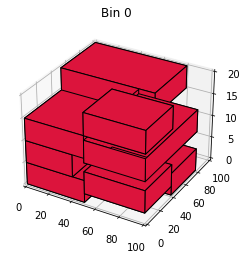

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
def getSolutionBox(i):
    box = boxes[i]
    used_in = [b for b in B if solution.get_value(u[i][b]) == 1]
    if len(used_in) == 0:
        return None
    bin = used_in[0]
    return Box(
        box.id,
        solution.get_value(x[i]),
        solution.get_value(y[i]),
        solution.get_value(z[i]),
        box.w,
        box.d,
        box.h,
        bin)

def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def getCubeCollection(boxes,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(boxes)
    g = []
    for box in boxes:
        g.append(cuboid_data((box["x"], box["y"], box["z"]), (box["width"], box["depth"], box["height"])))
    return Poly3DCollection(np.concatenate(g), facecolors=np.repeat(colors,6), **kwargs)

def plotBox(box, ax=None,**kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data((box["x"], box["y"], box["z"]), (box["width"], box["depth"], box["height"]) )
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, **kwargs)
        surf.patch.set_edgecolor('black')
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, color="black", **kwargs)

colors = ["crimson","limegreen", "navy", "purple"]

if solution and solution.is_valid_solution():
    solutions = [getSolutionBox(i) for i in I]
    milpBoxes = [sol.to_dict() for sol in solutions if sol != None]
    openedBins = [b for b in B if solution.get_value(v[b]) == 1]
    binPerRows = min(len(openedBins), 4)
    plotRows = int(len(openedBins)/binPerRows)
    fig = plt.figure(figsize=plt.figaspect(plotRows/binPerRows))
    idx = 0
    for bin in openedBins:
        idx += 1
        ax = fig.add_subplot(plotRows, binPerRows, idx, projection='3d')
        ax.set_title("Bin " + str(bin))
        ax.set_zlim(0, max([box["z"]+box["height"] for box in milpBoxes if box["bin"] == bin]))
        ax.set_ylim(0, D)
        ax.set_xlim(0, W)
        ax.add_collection3d(getCubeCollection([box for box in milpBoxes if box["bin"] == bin], colors=colors, edgecolor="k"))
else:
    print("Infeasible")

In [59]:
## Check solution
def overlaps(xmin1, xmin2, xmax1, xmax2):
    return xmax1 > xmin2 and xmin1 < xmax2

def checkSolution():
    solutions = [getSolutionBox(i) for i in I]
    nonNulls = [box for box in solutions if box != None]
    if len(nonNulls) != len(originalBoxes):
        return False
    for box in nonNulls:
        for other in nonNulls:
            if other != box:
                overlapX = overlaps(box.x, other.x, box.x + box.w, other.x + other.w)
                overlapY = overlaps(box.y, other.y, box.y + box.d, other.y + other.d)
                overlapZ = overlaps(box.z, other.z, box.z + box.h, other.z + other.h)
                if overlapX and overlapY and overlapZ:
                    return False
    return True
    

if not checkSolution():
    print("ERROR!")
else:
    print("OK!")

OK!


## Heuristic Solution

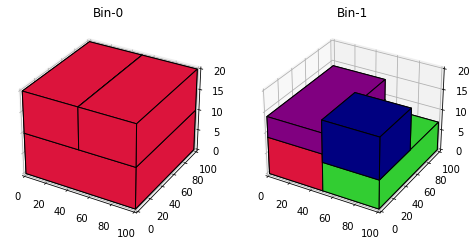

In [19]:
import requests
import time

boxes = originalBoxes

class Problem:
    def __init__(self, W, D, H, boxes):
        self.bins = [
            {
                "id": "Bin",
                "width": W,
                "depth": D,
                "height": H,
                "maxLoad": 999.0
            }
        ]
        self.boxes = boxes
        self.configuration = {
            "layer_packing": False,
            "support_area_threshold": 0.7,
            "overflow": 0,
            "tolerance": 0
        }
        self.solution = None
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
        

prob = Problem(W, D, H, [boxes[i].to_packer_box() for i in I])
r = requests.post("http://localhost:4567/jobs", data=prob.toJSON())

jobId = r.json()["job_id"]

sol = None
while(sol == None):
    time.sleep(0.2)
    sol = requests.get("http://localhost:4567/jobs/" + str(jobId))
    if sol.status_code == 500:
        break
    if not sol.status_code == 200:
        sol = None

if sol.json()["status"] == "completed":
    solBins = sol.json()["solution"]["bins"]
    binPerRows = min(len(solBins), 4)
    plotRows = int(len(solBins)/binPerRows)
    fig = plt.figure(figsize=plt.figaspect(plotRows/binPerRows))
    idx = 0
    for bin in solBins:
        idx += 1
        ax = fig.add_subplot(plotRows, binPerRows, idx, projection='3d')
        ax.set_title(bin["id"])
        ax.set_zlim(0, H)
        ax.set_ylim(0, D)
        ax.set_xlim(0, W)
        ax.add_collection3d(getCubeCollection([box for box in bin["boxes"]], colors=colors, edgecolor="k"))